Here, I will be conducting an unsupervised clustering of sales data on the customer's records from a groceries firm's database. Customer segmentation is the process of grouping customers into segments that reflect peculiarities among customers in each group. I will divide customers into groups to optimize the relevance of each customer to the business. To modify products according to distinct needs and behaviours of the customers. It also helps the business to provide to the needs of different types of customers which consequently leads to business growth.

In [164]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [5]:
pd.set_option('display.max_columns',None)

In [165]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep=",")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [166]:
#Stripping the Marital Status column to align the values to left.
data['Marital_Status'] = data['Marital_Status'].str.strip()

In [167]:
#Dropping NaN values
data = data.dropna()
print("The number of data values after dropping NaN values is:", len(data))

The number of data values after dropping NaN values is: 2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record.

Thus to get the values I must check the newest and oldest recorded dates.                                                                                                                           

In [168]:
#To get newest and oldest customers
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
dates = []
for x in data["Dt_Customer"]:
    x = x.date()
    dates.append(x)  
#Dates of the oldest and newest set of customers
print("The oldest customer's purchase date on record is:",min(dates))
print("The newest customer's purchase date on record is:",max(dates))

The oldest customer's purchase date on record is: 2012-07-30
The newest customer's purchase date on record is: 2014-06-29


In [169]:
#Created a feature "Newest Cust. Set"
days = []
d1 = max(dates) #taking it to be the newest customer
for x in dates:
    delta = d1 - x
    days.append(delta)
data["Newest Cust. Set"] = days
data["Newest Cust. Set"] = pd.to_numeric(data["Newest Cust. Set"], errors="coerce")

In [170]:
print("The total categories in the variable: Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("The total categories in the variable: Education:\n", data["Education"].value_counts())

The total categories in the variable: Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

The total categories in the variable: Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


Next, I will be performing the following steps to creatr some new variables:

Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
Create another feature "Household" out of "Marital_Status" to extract the living situation of couples.
Create a feature "No_Children" to indicate total children in a household that is, kids and teenagers.
To get further clarity of household, Creating feature indicating "Family_Size"
Create a feature "Is_Parent" to indicate parenthood status
Lastly, I will create three categories in the "Education" by simplifying its value counts.
Dropping some of the redundant features

In [171]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2022-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Creating Nature of household from marital status"Alone"
data["Household"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Creating the No_Children column from the Kidhome and Teenhome columns
data["No_Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Household"].replace({"Alone": 1, "Partner":2})+ data["No_Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.No_Children> 0, 1, 0)

#Creating 3 clusters from the Education column
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#Renaming some columns for ease of understanding
data=data.rename(columns={"MntWines": "Amt_Wines","MntFruits":"Amt_Fruits","MntMeatProducts":"Amt_Meat","MntFishProducts":"Amt_Fish","MntSweetProducts":"Amt_Sweets","MntGoldProds":"Amt_Gold"})

#Some variables are no longer neccessary, so lets drop them.
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [172]:
# Statistical Summary of the data set
data.describe()

,Income,Kidhome,Teenhome,Recency,Amt_Wines,Amt_Fruits,Amt_Meat,Amt_Fish,Amt_Sweets,Amt_Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Newest Cust. Set,Age,Spent,No_Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,3.054423e+16,53.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,26.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.555200e+16,45.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.071520e+16,52.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.570560e+16,63.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.039360e+16,129.000000,2525.000000,3.000000,5.000000,1.000000


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

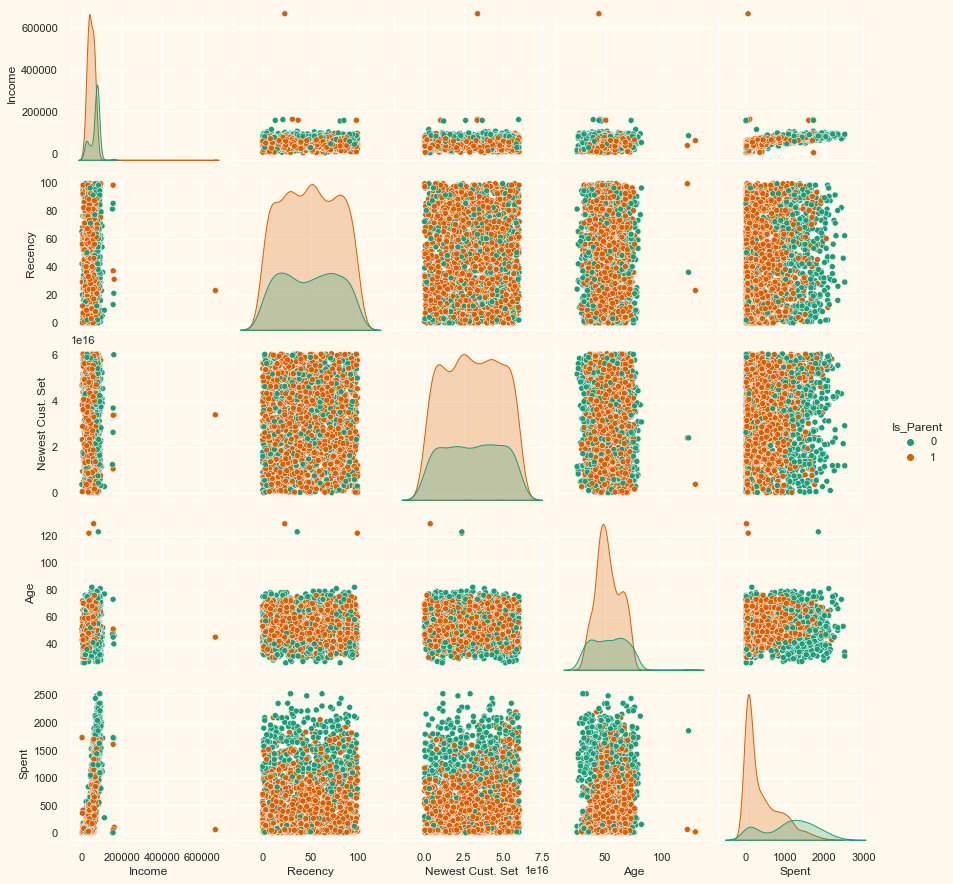

In [173]:
#Plotting following variables
sns.color_palette("Set2")
plot = ["Income", "Recency", "Newest Cust. Set", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
plt.show()

sns.pairplot(data[plot],hue ='Is_Parent', palette='Dark2')

In [174]:
#To avoid a skewed analysis, outliers have to be removed from the Age and Income columns. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The number of data values after removing the outliers are:", len(data))

The number of data values after removing the outliers are: 2212


<AxesSubplot:>

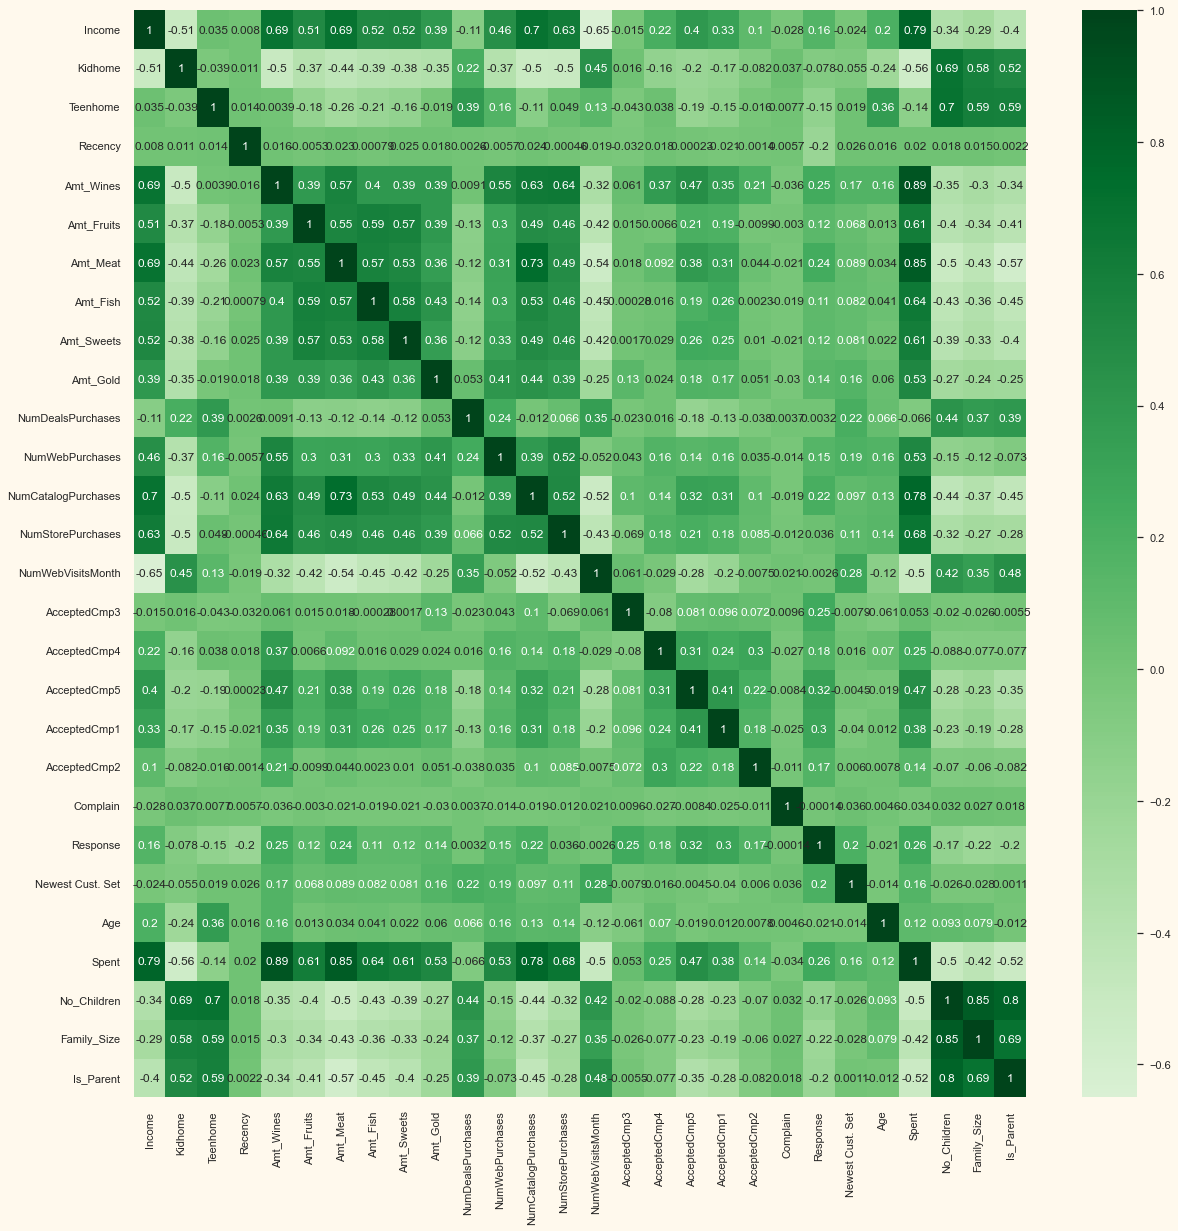

In [175]:
#To get the correlation matrix
corrplot= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrplot,annot=True, cmap='Greens', center=0)

In this section, I will be preprocessing the data to perform clustering operations.

The following steps are applied to preprocess the data:

Label encoding the categorical features
Scaling the features using the standard scaler
Creating a subset dataframe for dimensionality reduction

In [177]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Household']


In [178]:
#Finding all integer columns in the data set
int_col = []
for x in data.dtypes.index:
    if data.dtypes[x] == 'int64':
        int_col.append(x)
        
int_col

['Kidhome',
 'Teenhome',
 'Recency',
 'Amt_Wines',
 'Amt_Fruits',
 'Amt_Meat',
 'Amt_Fish',
 'Amt_Sweets',
 'Amt_Gold',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response',
 'Newest Cust. Set',
 'Age',
 'Spent',
 'No_Children',
 'Family_Size']

In [112]:
#Finding all object columns in the data set
col_object = []
for x in data.dtypes.index:
    if data.dtypes[x] == 'object':
        col_object.append(x)
        
col_object

[]

In [179]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for x in object_cols:
    data[x]=data[[x]].apply(LE.fit_transform)
    
print("All variables are now numerical")

All variables are now numerical


In [180]:
#Creating a copy of data
data1 = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
data1 = data1.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(data1)
scaled_data1 = pd.DataFrame(scaler.transform(data1),columns= data1.columns )
print("All features are now scaled")

All features are now scaled


In [181]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_data1.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Amt_Wines,Amt_Fruits,Amt_Meat,Amt_Fish,Amt_Sweets,Amt_Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Newest Cust. Set,Age,Spent,Household,No_Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In this project, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. That is the reason for performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

Steps in this section:

Dimensionality reduction with PCA
Plotting the reduced dataframe
Dimensionality reduction with PCA

For this project, I will be reducing the dimensions to 3.

In [182]:
#Initiating PCA to reduce dimentions aka variables to 3
pca = PCA(n_components=3)
pca.fit(scaled_data1)
PCA_ds = pd.DataFrame(pca.transform(scaled_data1), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.114238e-16,2.878602,-5.978123,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,-2.128095e-17,1.709469,-4.194757,-1.323932,-0.173716,1.234923,6.168185
col3,2212.0,4.618819e-17,1.231685,-3.625184,-0.853556,-0.051292,0.863841,6.746845


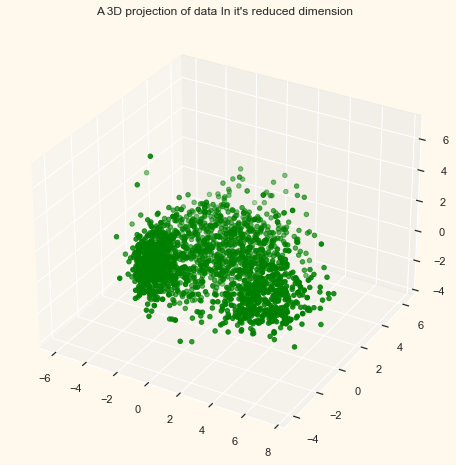

In [183]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="green", marker="o")
ax.set_title("A 3D projection of data In it's reduced dimension")
plt.show()

Now that I have reduced the attributes to three dimensions, I will be performing clustering using the Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method. It involves merging examples until the desired number of clusters is achieved.

Steps involved in the Clustering:

Elbow Method to discover the number of clusters to be formed
Clustering via Agglomerative Clustering
Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


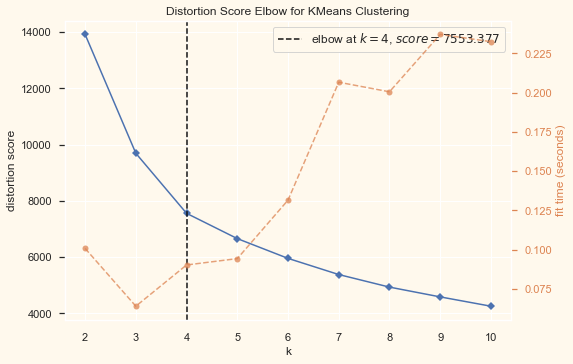

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [184]:
# Quick examination of elbow method to find number of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that four will be an optimal number of clusters for this data. Next, we will be fitting the Agglomerative Clustering Model to get the final clusters.

In [185]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

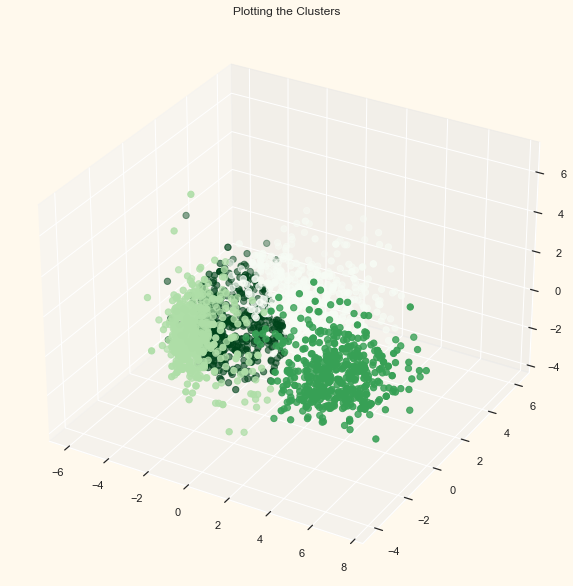

In [186]:
#Plotting the clusters
fig = plt.figure(figsize=(10,12))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = 'Greens')
ax.set_title("Plotting the Clusters")
plt.show()

## Evaluating the models used

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

Firstly, let us have a look at the group distribution of clustring

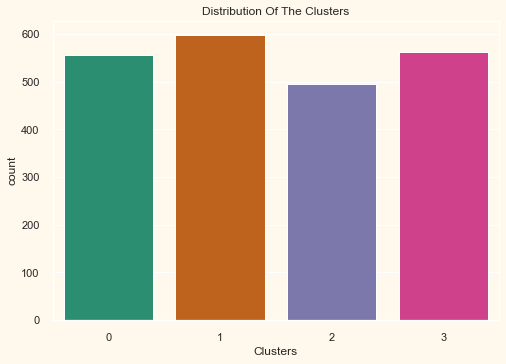

In [151]:
#Plotting the clusters' countplot
pl = sns.countplot(x=data["Clusters"], palette= 'Dark2')
pl.set_title("Distribution Of The Clusters")
plt.show()

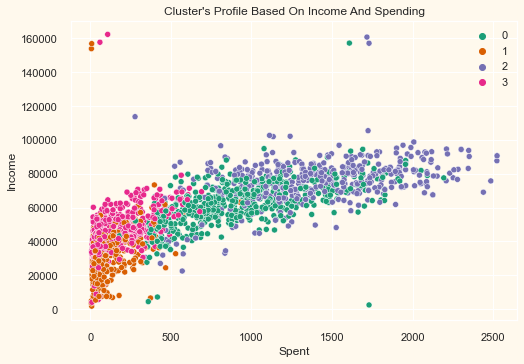

In [187]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= 'Dark2')
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Income vs spending plot shows the clusters pattern

group 0: high spending & average income
group 1: high spending & high income
group 2: low spending & low income
group 3: high spending & low income
Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

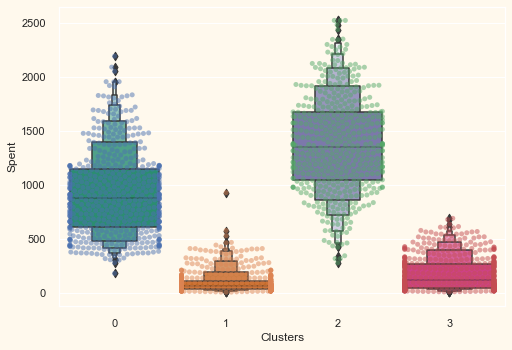

In [188]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette='Dark2')
plt.show()

From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.

Let us next explore how did our campaigns do in the past.

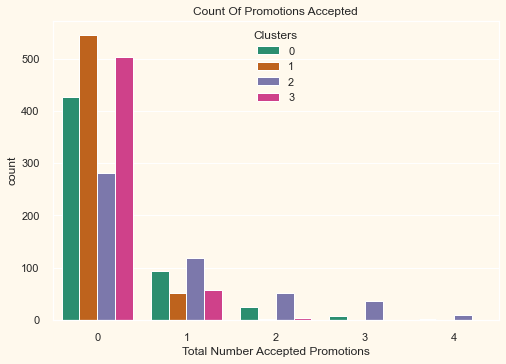

In [137]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promotions"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promotions"],hue=data["Clusters"], palette= 'Dark2')
pl.set_title("Count Of Promotions Accepted")
pl.set_xlabel("Total Number Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

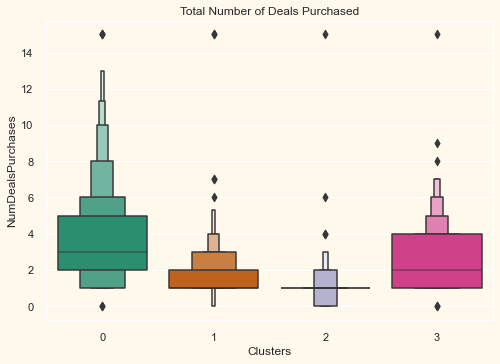

In [138]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= 'Dark2')
pl.set_title("Total Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. However, our star customers cluster 1 are not much into the deals. Nothing seems to attract cluster 2 overwhelmingly

## Profiling the analysis

Now that we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 576x396 with 0 Axes>

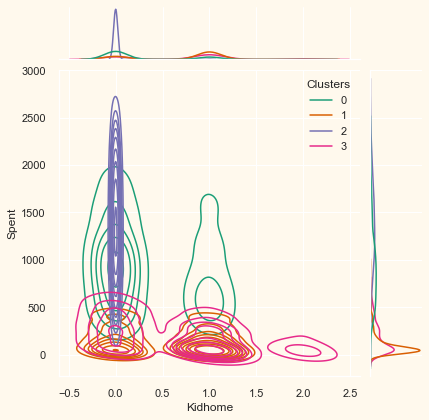

<Figure size 576x396 with 0 Axes>

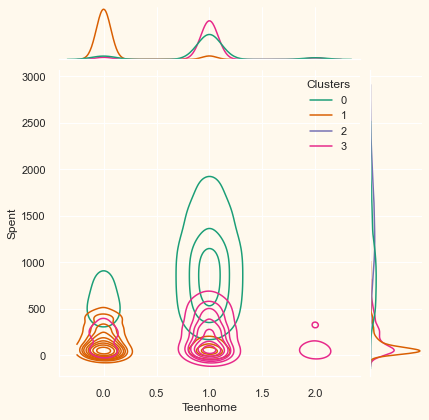

<Figure size 576x396 with 0 Axes>

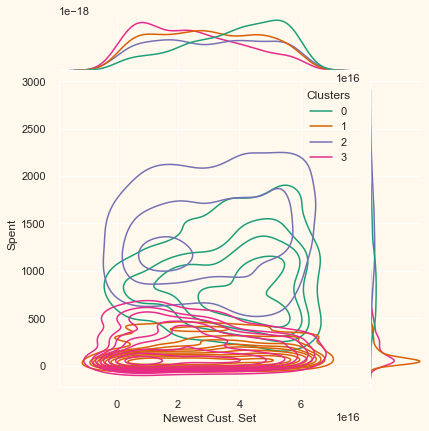

<Figure size 576x396 with 0 Axes>

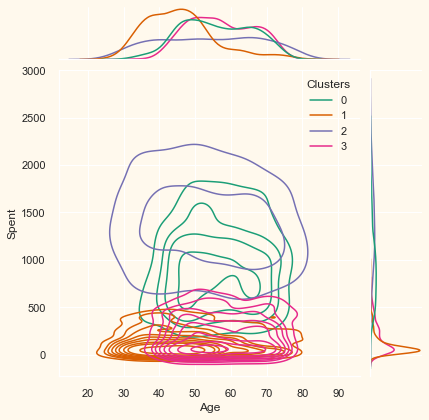

<Figure size 576x396 with 0 Axes>

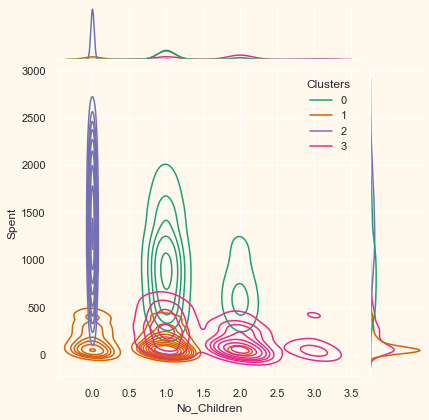

<Figure size 576x396 with 0 Axes>

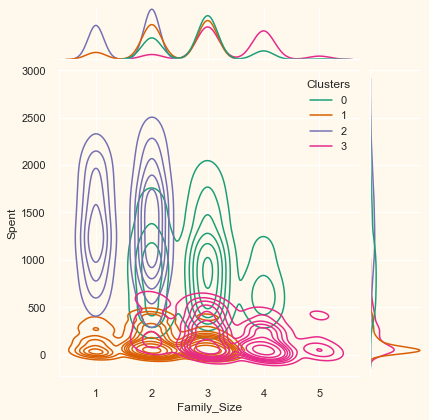

<Figure size 576x396 with 0 Axes>

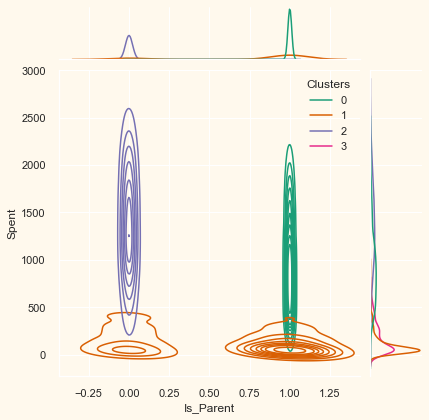

<Figure size 576x396 with 0 Axes>

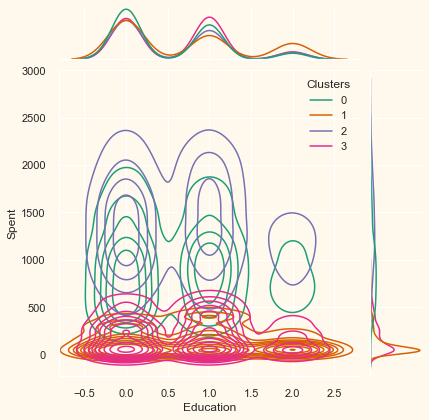

<Figure size 576x396 with 0 Axes>

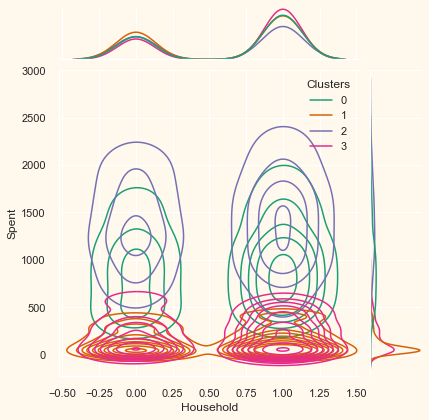

In [141]:
To_Indiv = [ "Kidhome","Teenhome","Newest Cust. Set", "Age", "No_Children", "Family_Size", "Is_Parent", "Education","Household"]

for x in To_Indiv:
    plt.figure()
    sns.jointplot(x=data[x], y=data["Spent"], hue =data["Clusters"], kind="kde", palette='Dark2')
    plt.show()

In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by agglomerative clustering. I came up with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. This can be used in planning better marketing strategies.